In [220]:
import torch
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
import sys
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
import time
import copy
import matplotlib.pyplot as plt
import os
import random
import pandas as pd

seed=42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

In [221]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [222]:
# Normalisation des images pour les modèles pré-entraînés PyTorch

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [223]:
train_directory = "/content/gdrive/MyDrive/ProjetFromage/augmentated_data/train/"
test_directory = "/content/gdrive/MyDrive/ProjetFromage/augmentated_data/test/"
dataset_train_full = datasets.ImageFolder(train_directory, data_transforms)
dataset_test = datasets.ImageFolder(test_directory, data_transforms)

# split en train, val et test à partir de la liste complète
np.random.seed(42)
samples_train, samples_val = train_test_split(dataset_train_full.samples,test_size=0.2)
samples_test = dataset_test.samples

print("Nombre d'images de train : %i" % len(samples_train))
print("Nombre d'images de val : %i" % len(samples_val))
print("Nombre d'images de test : %i" % len(samples_test))

Nombre d'images de train : 13728
Nombre d'images de val : 3432
Nombre d'images de test : 954


In [224]:
BATCH_SIZE = 8

# on définit les datasets et loaders pytorch à partir des listes d'images de train / val / test
dataset_train = datasets.ImageFolder(train_directory, data_transforms)
dataset_train.samples = samples_train
dataset_train.imgs = samples_train
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

dataset_val = datasets.ImageFolder(train_directory, data_transforms)
dataset_val.samples = samples_val
dataset_val.imgs = samples_val

torch.manual_seed(42)

In [225]:
# détermination du nombre de classes
# vérification que les labels sont bien dans [0, nb_classes]
labels=[x[1] for x in samples_train]
if np.min(labels) != 0:
    print("Error: labels should start at 0 (min is %i)" % np.min(labels))
    sys.exit(-1)
if np.max(labels) != (len(np.unique(labels))-1):
    print("Error: labels should go from 0 to Nclasses (max label = {}; Nclasse = {})".format(np.max(labels),len(np.unique(labels)))  )
    sys.exit(-1)
nb_classes = np.max(labels)+1
print("Apprentissage sur {} classes".format(nb_classes))

Apprentissage sur 43 classes


In [226]:
# on définit le device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [227]:
# on définit une fonction d'évaluation
results_per_label_dic = {}
for i in range (43):
    results_per_label_dic[i] = [0, 0]
corr = []

def evaluate(model, dataset):
    n_correct_per_label = np.zeros(43)
    avg_loss = 0.
    avg_accuracy = 0
    loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False, num_workers=2)
    for data in loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        n_correct = torch.sum(preds == labels)
        corr.append((labels, preds))
        for i in range (43):
            n_correct_per_label[i] += torch.sum(torch.sum((labels == i)[preds == i])).item()
            results_per_label_dic[i][0] += torch.sum(labels == i).item()
        
        avg_loss += loss.item()
        avg_accuracy += n_correct

    for i in range (43):
        results_per_label_dic[i][1] = n_correct_per_label[i]/results_per_label_dic[i][0]
        
    return avg_loss / len(dataset), float(avg_accuracy) / len(dataset)

# fonction d'entraînement du modèle
PRINT_LOSS = False

def train_model(model, loader_train, data_val, optimizer, criterion, n_epochs=10, scheduler=None):
  
    since = time.time()
    best_acc=0
    best_model_wts = copy.deepcopy(model.state_dict())
    saved_acc=[]
    lrs=[]

    for epoch in range(n_epochs): 
        batch=0
        print("EPOCH % i" % epoch)
        for i, data in enumerate(loader_train):
            batch+=1
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) 
            optimizer.zero_grad() 
            outputs = model(inputs) 
            
            loss = criterion(outputs, labels) 
            if PRINT_LOSS:
                model.train(False)
                loss_val, accuracy = evaluate(model, data_val)
                model.train(True)
                #print("{} loss train: {:1.4f}\t val {:1.4f}\tAcc (val): {:.1%}".format(i, loss.item(), loss_val, accuracy   ))
            
            loss.backward() 
            optimizer.step() 
            lrs.append(optimizer.param_groups[0]["lr"])
            if scheduler:
              scheduler.step()
            #print(f'Batch {batch} : {optimizer.param_groups[0]["lr"]}')

        model.train(False)
        loss_val, accuracy = evaluate(model, data_val)
        saved_acc.append(accuracy)
        #early stopping
        if accuracy>best_acc:
          best_acc=accuracy
          best_model_wts = copy.deepcopy(model.state_dict())
        model.train(True)
        print("{} loss train: {:1.4f}\t val {:1.4f}\tAcc (val): {:.1%}".format(i, loss.item(), loss_val, accuracy   ))

    plt.plot(lrs)
    model.load_state_dict(best_model_wts)
    return best_acc


In [228]:
new_model=torch.load("/content/gdrive/MyDrive/ProjetFromage/ResNetFT_model.pth")
criterion = nn.CrossEntropyLoss()
loss, accuracy = evaluate(new_model, dataset_test)
print("Accuracy (test): %.1f%%" % (100 * accuracy))

Accuracy (test): 80.3%


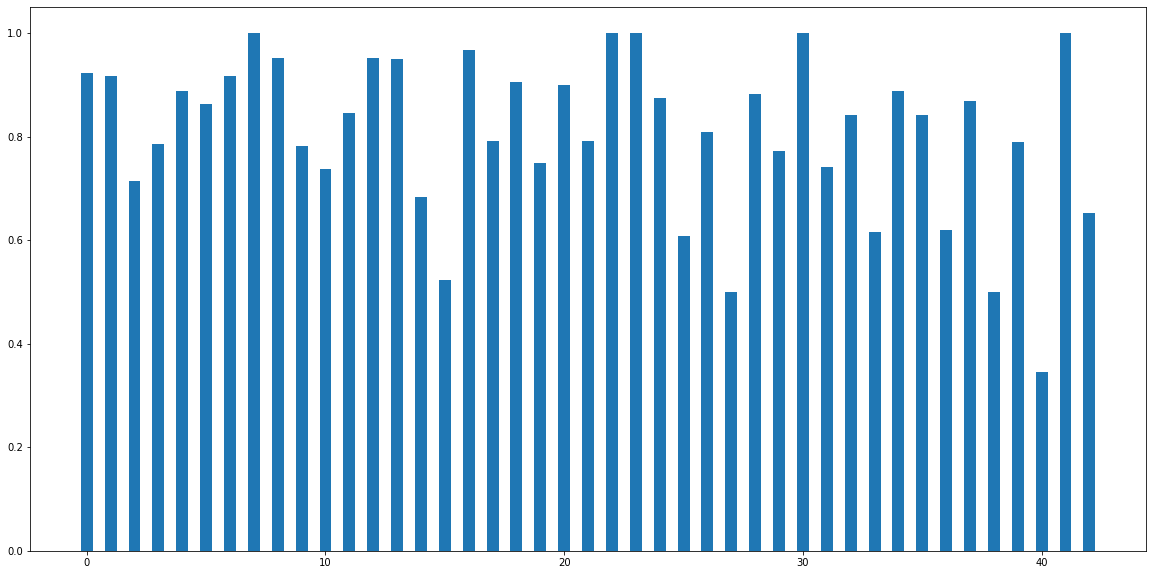

Classes avec accuracy >= 80% : 0.5581395348837209
Classes avec accuracy <= 60% : 0.09302325581395349


In [229]:
results_per_label = results_per_label_dic.items()
plt.figure(figsize=(20, 10))
plt.bar([r[0] for r in results_per_label], [r[1][1] for r in results_per_label], width = 0.5)
plt.show()
print(f'Classes avec accuracy >= 80% : {len(list(filter(lambda sl: sl[1][1] >= 0.80, results_per_label)))/43}\nClasses avec accuracy <= 60% : {len(list(filter(lambda sl: sl[1][1] <= 0.60, results_per_label)))/43}')

In [230]:
print(f'Les classes les plus difficiles sont :\n{list(filter(lambda d: d[1] == 40, d))[0][0][60:-8]}\n{list(filter(lambda d: d[1] == 38, d))[0][0][60:-8]}\n{list(filter(lambda d: d[1] == 27, d))[0][0][60:-8]}\n{list(filter(lambda d: d[1] == 15, d))[0][0][60:-8]}')

Les classes les plus difficiles sont :
Tomme des Pyr+®n+®es fromage
Tomette de Brebis fromage
Ossau-iraty fromage
Coulommiers fromage
